Install API Kaggle untuk download dataset

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gregoriusyuristama","key":"e45cfa20eb24d9de270c469b4435ce41"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d muhammetvarl/laptop-price

  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 17.7MB/s]


In [6]:
! unzip /content/laptop-price.zip

Archive:  /content/laptop-price.zip
  inflating: laptop_price.csv        


Import Library yang diperlukan

In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import  OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

Helper Function

In [8]:
# Fungsi bantuan untuk mengubah dari TB ke GB
def converter(x):
    try:
        return pd.eval(x)
    except:
        return x

# Fungsi bantuan untuk mengevaluasi grid search
def evaluate(model, test_features, test_labels):
    mse = mean_squared_error(y_true=test_labels, y_pred=model.predict(test_features))/1e3
    print('Model Performance')
    print('MSE = ',mse)
    
    return mse

# **Tahapan Loading data dan Data Cleaning**






In [9]:
df = pd.read_csv('/content/laptop_price.csv', encoding='latin-1')
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


Drop column laptop_ID karena tidak diperlukan

In [10]:
df.drop(columns='laptop_ID', inplace=True)

Mengecek Missing Value

In [11]:
df.isnull().sum().sort_values(ascending=False)

Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

Mengecek tipe data

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   Product           1303 non-null   object 
 2   TypeName          1303 non-null   object 
 3   Inches            1303 non-null   float64
 4   ScreenResolution  1303 non-null   object 
 5   Cpu               1303 non-null   object 
 6   Ram               1303 non-null   object 
 7   Memory            1303 non-null   object 
 8   Gpu               1303 non-null   object 
 9   OpSys             1303 non-null   object 
 10  Weight            1303 non-null   object 
 11  Price_euros       1303 non-null   float64
dtypes: float64(2), object(10)
memory usage: 122.3+ KB


In [13]:
df['Weight']

0       1.37kg
1       1.34kg
2       1.86kg
3       1.83kg
4       1.37kg
         ...  
1298     1.8kg
1299     1.3kg
1300     1.5kg
1301    2.19kg
1302     2.2kg
Name: Weight, Length: 1303, dtype: object

In [14]:
# kolom weight bertipe object sehingga perlu diubah ke float
df['weight_float']=df.Weight.replace('kg','',regex=True).astype(float)
df.drop(['Weight'], axis=1,inplace=True)
df['weight_float']

0       1.37
1       1.34
2       1.86
3       1.83
4       1.37
        ... 
1298    1.80
1299    1.30
1300    1.50
1301    2.19
1302    2.20
Name: weight_float, Length: 1303, dtype: float64

In [15]:
df['Ram']

0        8GB
1        8GB
2        8GB
3       16GB
4        8GB
        ... 
1298     4GB
1299    16GB
1300     2GB
1301     6GB
1302     4GB
Name: Ram, Length: 1303, dtype: object

In [16]:
# Kolom ram bertipe object sehingga perlu diubah ke float
df['ram_int']=df.Ram.replace('GB','',regex=True).astype(int)
df.drop(['Ram'], axis=1,inplace=True)
df['ram_int']

0        8
1        8
2        8
3       16
4        8
        ..
1298     4
1299    16
1300     2
1301     6
1302     4
Name: ram_int, Length: 1303, dtype: int64

Kolom ScreenResolution memiliki beberapa informasi yang dapat dipisah

In [17]:
df['ScreenResolution'].value_counts()

Full HD 1920x1080                                507
1366x768                                         281
IPS Panel Full HD 1920x1080                      230
IPS Panel Full HD / Touchscreen 1920x1080         53
Full HD / Touchscreen 1920x1080                   47
1600x900                                          23
Touchscreen 1366x768                              16
Quad HD+ / Touchscreen 3200x1800                  15
IPS Panel 4K Ultra HD 3840x2160                   12
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     11
4K Ultra HD / Touchscreen 3840x2160               10
4K Ultra HD 3840x2160                              7
Touchscreen 2560x1440                              7
IPS Panel 1366x768                                 7
IPS Panel Quad HD+ / Touchscreen 3200x1800         6
IPS Panel Retina Display 2560x1600                 6
IPS Panel Retina Display 2304x1440                 6
Touchscreen 2256x1504                              6
IPS Panel Touchscreen 2560x1440               

Memisahkan kolom ScreenResolution menjadi resolution_width dan resolution_height

In [18]:
df['resolution_width']=df['ScreenResolution'].str.split().str[-1].str.split("x").str[0].astype(int)
df['resolution_height']=df['ScreenResolution'].str.split().str[-1].str.split("x").str[1].astype(int)
df.drop(['ScreenResolution'],axis=1,inplace=True)
df[['resolution_width','resolution_height']]

,resolution_width,resolution_height
0,2560,1600
1,1440,900
2,1920,1080
3,2880,1800
4,2560,1600
...,...,...
1298,1920,1080
1299,3200,1800
1300,1366,768
1301,1366,768


Kolom Memory memiliki beberapa informasi yang dapat dipisah

In [19]:
df['Memory'].value_counts()

256GB SSD                        412
1TB HDD                          223
500GB HDD                        132
512GB SSD                        118
128GB SSD +  1TB HDD              94
128GB SSD                         76
256GB SSD +  1TB HDD              73
32GB Flash Storage                38
2TB HDD                           16
64GB Flash Storage                15
512GB SSD +  1TB HDD              14
1TB SSD                           14
256GB SSD +  2TB HDD              10
1.0TB Hybrid                       9
256GB Flash Storage                8
16GB Flash Storage                 7
32GB SSD                           6
180GB SSD                          5
128GB Flash Storage                4
512GB SSD +  2TB HDD               3
16GB SSD                           3
512GB Flash Storage                2
1TB SSD +  1TB HDD                 2
256GB SSD +  500GB HDD             2
128GB SSD +  2TB HDD               2
256GB SSD +  256GB SSD             2
512GB SSD +  256GB SSD             1
5

Membagi kolom Memory menjadi 4 bagian, yaitu memory_1_size, memory_1_type, memory_2_size, memory_2_type

In [20]:
df['memory_count']=df['Memory'].str.split('+').str.len()
df['memory_1'] = df['Memory'].str.split('+').str[0]
df['memory_2'] = np.where(df['memory_count'] == 2, df['Memory'].str.split('+').str[1], 0)

df['memory_1_size'] = df['memory_1'].str.split().str[0]
df['memory_1_size'] = df['memory_1_size'].replace({'GB':'','TB':'*1024'},regex=True).map(converter)
df['memory_1_type'] = df['memory_1'].str.split(r'GB|TB').str[-1].str.strip()

df['memory_2_size'] = np.where(df['memory_count'] == 2, df['memory_2'].str.split().str[0],0)
df['memory_2_size'] = df['memory_2_size'].replace({'GB':'','TB':'*1024'},regex=True).map(converter)
df['memory_2_type'] = np.where(df['memory_count'] == 2,df['memory_2'].str.split(r'GB|TB').str[-1].str.strip(),"None")

df.drop(['Memory'], axis=1,inplace=True)

df.drop(['memory_1', 'memory_2'], axis=1,inplace=True)


In [21]:
df[['memory_1_size','memory_1_type','memory_2_size', 'memory_2_type']]

,memory_1_size,memory_1_type,memory_2_size,memory_2_type
0,128.0,SSD,0.0,None
1,128.0,Flash Storage,0.0,None
2,256.0,SSD,0.0,None
3,512.0,SSD,0.0,None
4,256.0,SSD,0.0,None
...,...,...,...,...
1298,128.0,SSD,0.0,None
1299,512.0,SSD,0.0,None
1300,64.0,Flash Storage,0.0,None
1301,1024.0,HDD,0.0,None


Membagi kolom Cpu menjadi 3 yaitu : cpu_brand, cpu_clock, dan cpu_series

In [22]:
df['Cpu'].value_counts()

Intel Core i5 7200U 2.5GHz       190
Intel Core i7 7700HQ 2.8GHz      146
Intel Core i7 7500U 2.7GHz       134
Intel Core i7 8550U 1.8GHz        73
Intel Core i5 8250U 1.6GHz        72
                                ... 
Intel Core M M3-6Y30 0.9GHz        1
AMD A9-Series 9420 2.9GHz          1
Intel Core i3 6006U 2.2GHz         1
AMD A6-Series 7310 2GHz            1
Intel Xeon E3-1535M v6 3.1GHz      1
Name: Cpu, Length: 118, dtype: int64

In [23]:
df['cpu_brand'] = df['Cpu'].str.split().str[0]
df['cpu_clock'] = df['Cpu'].str.split().str[-1].replace('GHz','',regex=True).astype(float)
df['cpu_series'] = np.where(df['Cpu'].replace(r"Dual Core|Quad Core|-Series", 
                                              '', 
                                              regex=True
                                              ).str.split().str[-3] == 'Core', df['Cpu']
                            .replace(r"Dual Core|Quad Core|-Series", 
                                     '', 
                                     regex=True
                                     ).str.split().str[-2], df['Cpu']
                            .replace(r"Dual Core|Quad Core|-Series|E3-1505M|E3-1535M", 
                                     '', 
                                     regex=True).str.split().str[-3])
df.drop(['Cpu'], axis=1,inplace=True)

df[['cpu_clock', 'cpu_brand', 'cpu_series']]

,cpu_clock,cpu_brand,cpu_series
0,2.3,Intel,i5
1,1.8,Intel,i5
2,2.5,Intel,i5
3,2.7,Intel,i7
4,3.1,Intel,i5
...,...,...,...
1298,2.5,Intel,i7
1299,2.5,Intel,i7
1300,1.6,Intel,Celeron
1301,2.5,Intel,i7


In [24]:
df.describe()

,Inches,Price_euros,weight_float,ram_int,resolution_width,resolution_height,memory_count,memory_1_size,memory_2_size,cpu_clock
count,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000
mean,15.017191,1123.686992,2.038734,8.382195,1894.784344,1070.830391,1.159632,447.809670,172.285495,2.298772
std,1.426304,699.009043,0.665475,5.084665,494.641028,284.519410,0.366405,366.037159,412.255604,0.506340
min,10.100000,174.000000,0.690000,2.000000,1366.000000,768.000000,1.000000,8.000000,0.000000,0.900000
25%,14.000000,599.000000,1.500000,4.000000,1600.000000,900.000000,1.000000,256.000000,0.000000,2.000000
50%,15.600000,977.000000,2.040000,8.000000,1920.000000,1080.000000,1.000000,256.000000,0.000000,2.500000
75%,15.600000,1487.880000,2.300000,8.000000,1920.000000,1080.000000,1.000000,512.000000,0.000000,2.700000
max,18.400000,6099.000000,4.700000,64.000000,3840.000000,2160.000000,2.000000,2048.000000,2048.000000,3.600000


# **Data analysis**




Mengatasi Outlier

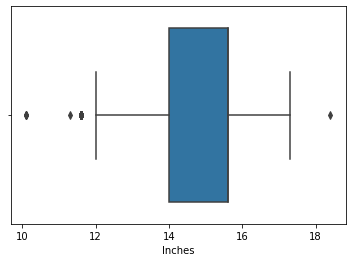

In [25]:
sns.boxplot(x=df['Inches'])

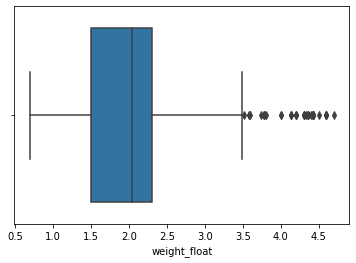

In [26]:
sns.boxplot(x=df['weight_float'])

In [27]:
df.shape

(1303, 19)

Dari boxplot diatas dapat dilihat terdapat outlier, sehingga outlier tersebut perlu dihapus agar mendapatkan hasil yang lebih baik



In [28]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR=Q3-Q1
df=df[~((df<(Q1-1.5*IQR))|(df>(Q3+1.5*IQR))).any(axis=1)]

df.shape

<ipython-input-28-9a16a617c526>:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df=df[~((df<(Q1-1.5*IQR))|(df>(Q3+1.5*IQR))).any(axis=1)]


(633, 19)

##**Univariate Analysis**

In [29]:
#convert all categorical columns to one hot encodding
cat_columns = sorted([col for col in df.columns if df[col].dtype=="O"])
cat_columns

['Company',
 'Gpu',
 'OpSys',
 'Product',
 'TypeName',
 'cpu_brand',
 'cpu_series',
 'memory_1_type',
 'memory_2_type']

In [30]:
num_features = df.select_dtypes(include=['float','int']).columns.to_list()
num_features

['Inches',
 'Price_euros',
 'weight_float',
 'ram_int',
 'resolution_width',
 'resolution_height',
 'memory_count',
 'memory_1_size',
 'memory_2_size',
 'cpu_clock']

Mencari insight pada kategori Company

          jumlah sampel  persentase
HP                  175        27.6
Lenovo              155        24.5
Dell                130        20.5
Acer                 55         8.7
Asus                 48         7.6
Toshiba              39         6.2
Mediacom              6         0.9
MSI                   5         0.8
Apple                 4         0.6
Vero                  4         0.6
Xiaomi                3         0.5
Samsung               3         0.5
Chuwi                 2         0.3
Fujitsu               2         0.3
LG                    2         0.3


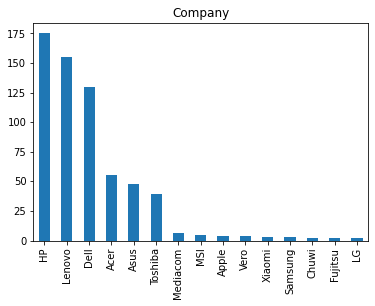

In [31]:
feature = cat_columns[0]
count = df[feature].value_counts()
percent = 100*df[feature].value_counts(normalize=True)
df_view = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
print(df_view)
count.plot(kind='bar', title=feature);

Pada barplot company diatas dapat dilihat bahwa pada dataset merk HP merupakan merk yang paling banyak dijual

              jumlah sampel  persentase
Windows 10              527        83.3
Windows 7                35         5.5
No OS                    31         4.9
Linux                    26         4.1
Chrome OS                 9         1.4
macOS                     2         0.3
Mac OS X                  2         0.3
Windows 10 S              1         0.2


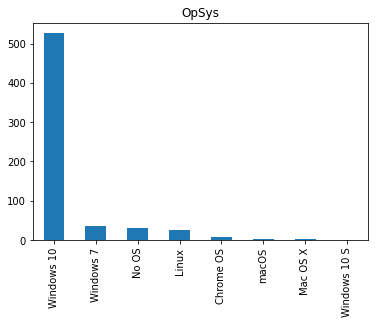

In [32]:
feature = cat_columns[2]
count = df[feature].value_counts()
percent = 100*df[feature].value_counts(normalize=True)
df_view = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
print(df_view)
count.plot(kind='bar', title=feature);

Pada berplot OpSys diatas dapat dilihat bahwa sistem operasi cukup bermacam-macam dan yang paling banyak adalah laptop dengan sistem operasi windows 10

       jumlah sampel  persentase
Intel            599        94.6
AMD               34         5.4


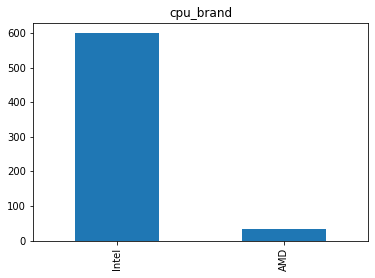

In [33]:
feature = cat_columns[5]
count = df[feature].value_counts()
percent = 100*df[feature].value_counts(normalize=True)
df_view = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
print(df_view)
count.plot(kind='bar', title=feature);

Pada barplot diatas dapat disimpulkan bahwa laptop dengan prosesor intel lebih banyak dijual dibanding AMD



         jumlah sampel  persentase
i5                 287        45.3
i7                 165        26.1
i3                  75        11.8
Celeron             50         7.9
Pentium             12         1.9
E                    9         1.4
A6                   9         1.4
Atom                 8         1.3
A9                   7         1.1
A12                  4         0.6
A8                   3         0.5
M                    2         0.3
A10                  1         0.2
A4                   1         0.2


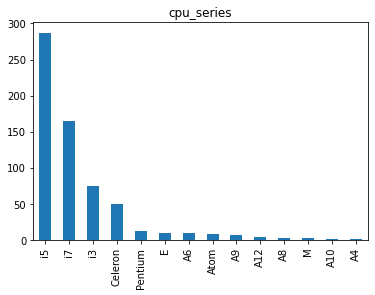

In [34]:
feature = cat_columns[6]
count = df[feature].value_counts()
percent = 100*df[feature].value_counts(normalize=True)
df_view = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
print(df_view)
count.plot(kind='bar', title=feature);

Dapat disimpulkan berdasarkan barplot diatas seri CPU yang paling banyak dijual adalah i5



               jumlah sampel  persentase
SSD                      461        72.8
HDD                      133        21.0
Flash Storage             38         6.0
Hybrid                     1         0.2


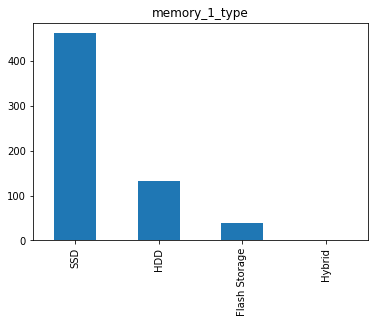

In [35]:
feature = cat_columns[7]
count = df[feature].value_counts()
percent = 100*df[feature].value_counts(normalize=True)
df_view = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
print(df_view)
count.plot(kind='bar', title=feature);

Dapat dilihat berdasarkan barplot diatas, kebanyakan laptop yang dijual sudah menggunakan SSD



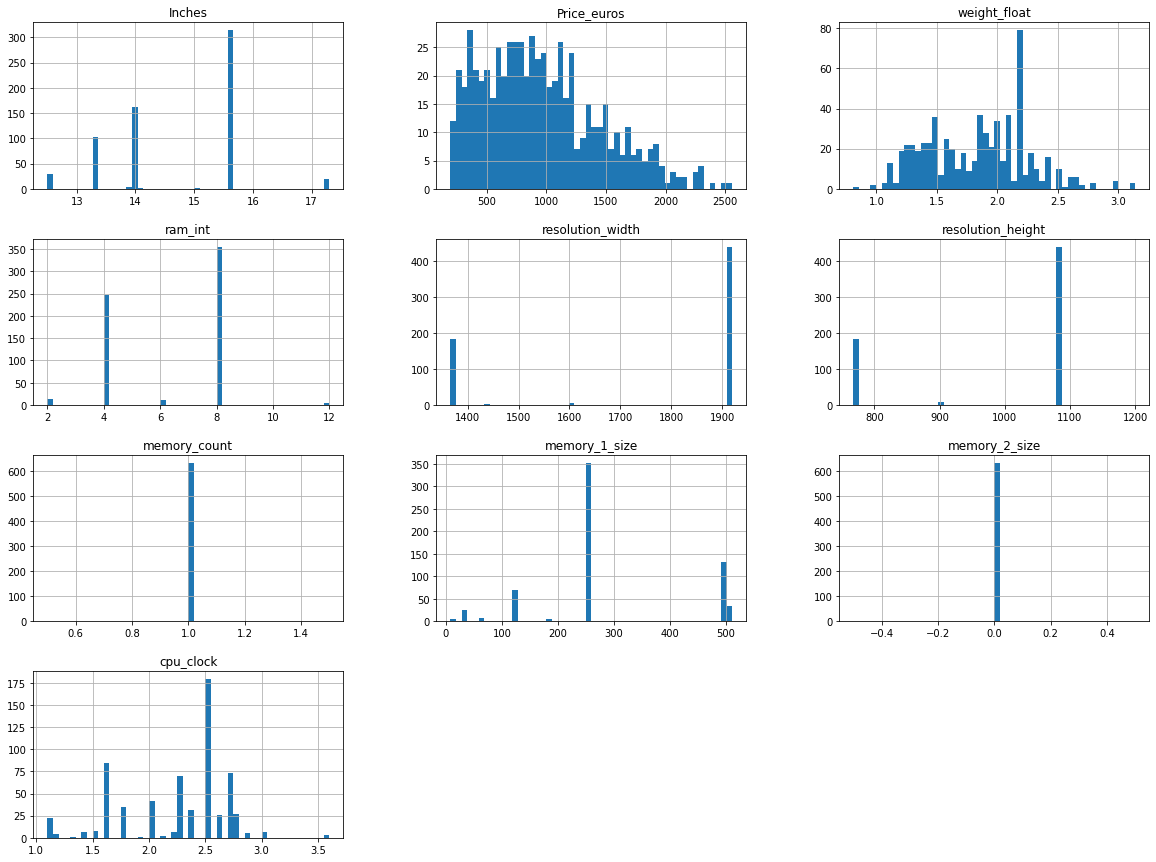

In [36]:
df.hist(bins=50, figsize=(20,15))
plt.show()

Karena pada histogram memory_count dan memory_2_size hanya memiliki 1 data saja maka kolom tersebut didrop

In [37]:
df.drop(['memory_count', 'memory_2_size'], axis=1,inplace=True)


## **Multivariate** Analysis

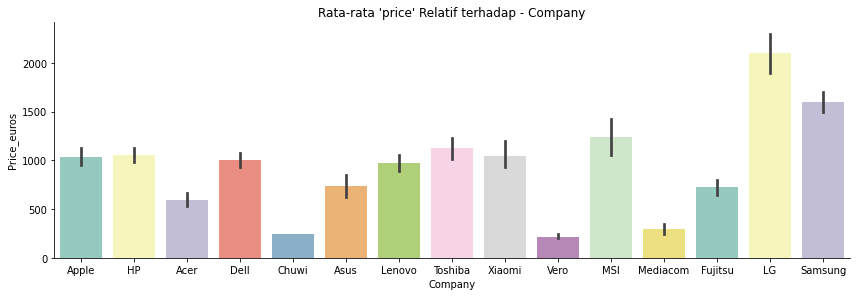

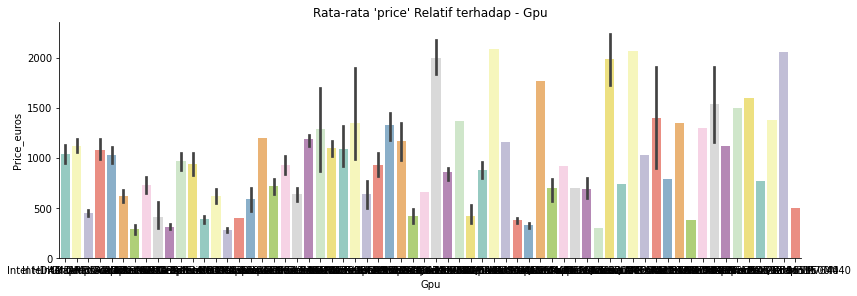

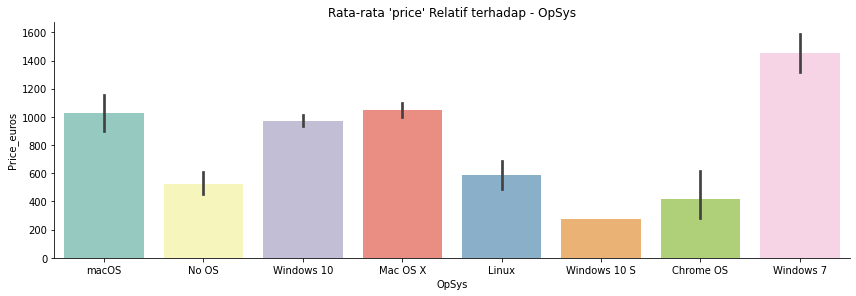

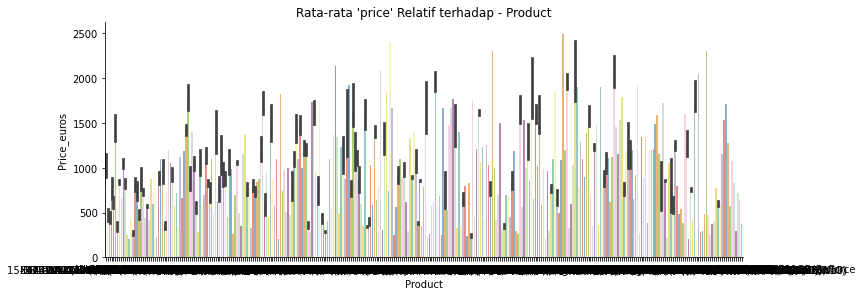

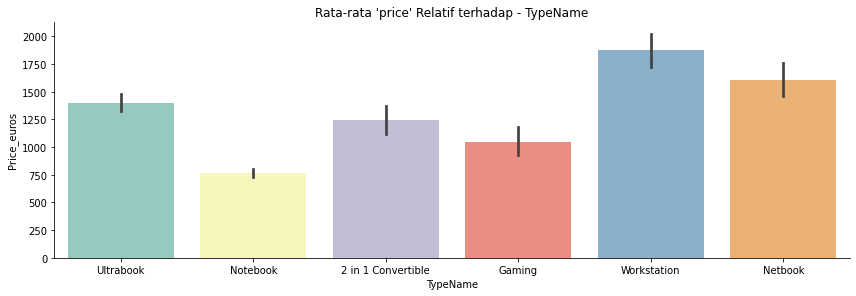

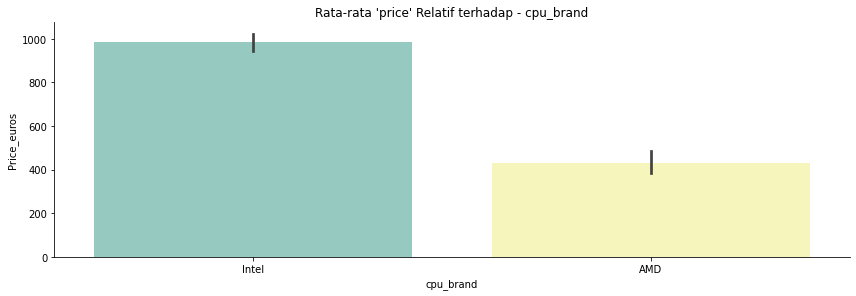

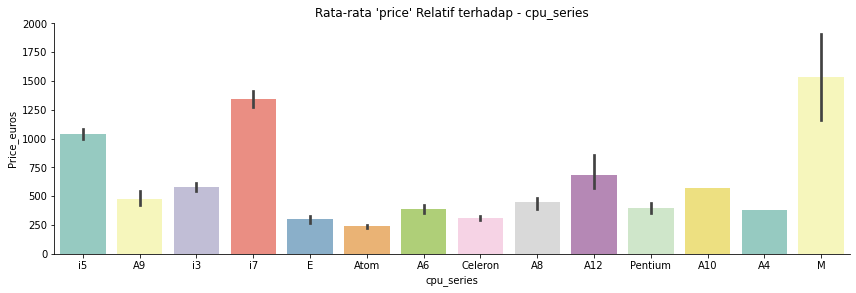

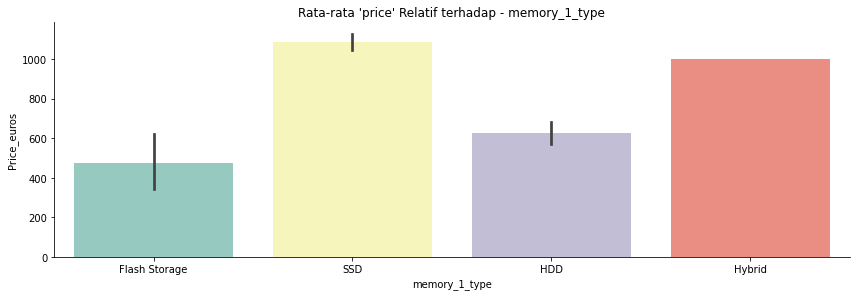

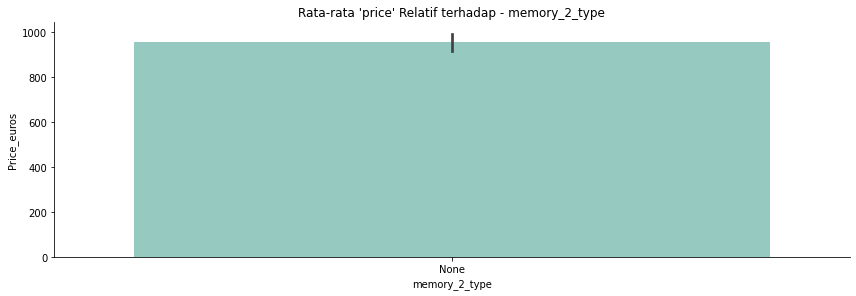

In [38]:
for col in cat_columns:
  sns.catplot(x=col, y="Price_euros", kind="bar", dodge=False, height = 4, aspect = 3,  data=df, palette="Set3")
  plt.title("Rata-rata 'price' Relatif terhadap - {}".format(col))

## **Terdapat beberapa poin yang didapat berdasarkan catplot diatas**

* Ternyata merk cukup berpengaruh terhadap harga, dapat dilihat merk chuwi memiliki harga laptop paling murah sedangkan merk laptop LG memiliki harga tingi
* Sistem operasi laptop juga ternyata cukup berpengaruh terhadap harga, dapat dilihat laptop dengan sistem operasi macOS memiliki harga paling tinggi
* Tipe laptop juga memiliki pengaruh terhadap harga, tipe notebook memiliki harga paling murah sedangkan yang paling mahal adalah workstation
* Seri CPU juga memiliki pengaruh terhadap harga, laptop dengan i7 cenderung memiliki harga lebih mahal dan seri M memiliki harga tertinggi
* Jenis memory/storage juga memiliki pengaruh terhadap harga, dimana laptop dengan harga SSD memiliki harga paling mahal disusul dengan jenis Hybrid
* Karena memory_2_type hanya memiliki 1 data saja yaitu None, maka kolom tersebut dihapus

In [39]:
df.drop(['memory_2_type'], axis=1,inplace=True)
cat_columns.remove('memory_2_type')

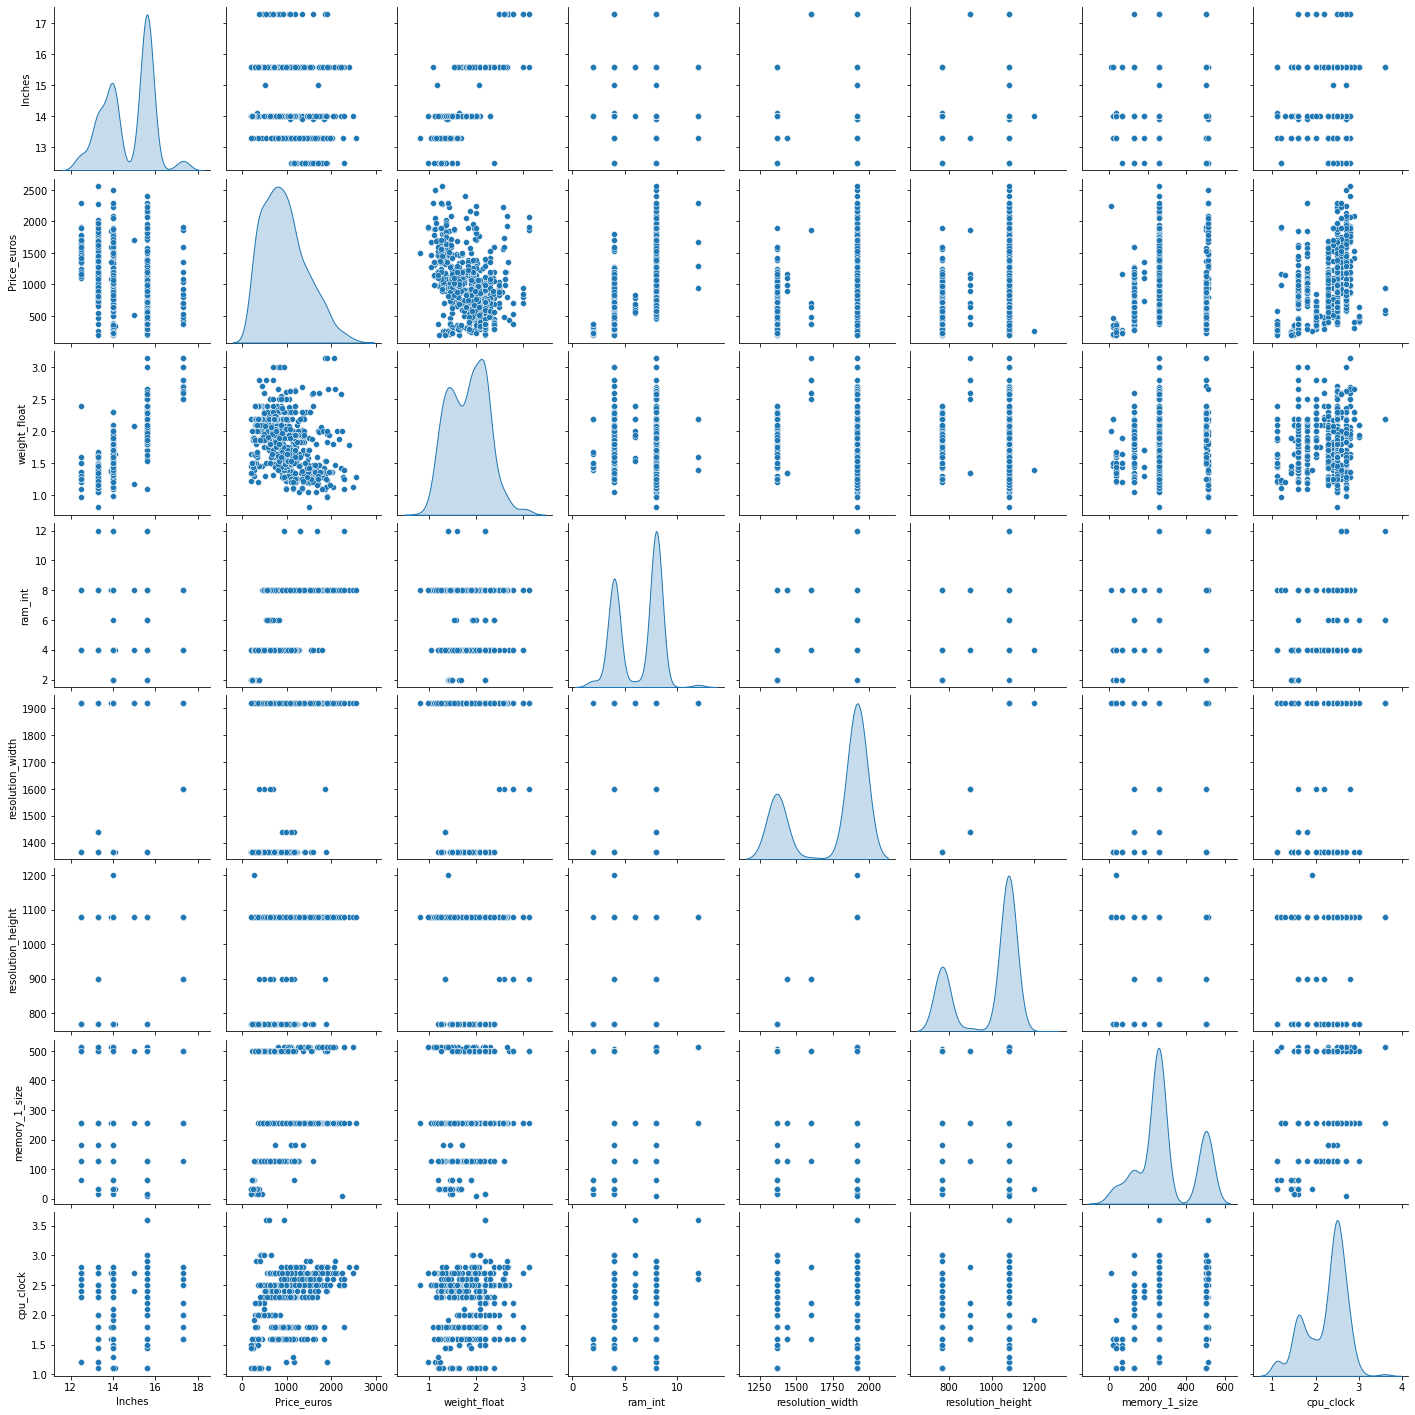

In [40]:
sns.pairplot(df, diag_kind = 'kde')

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

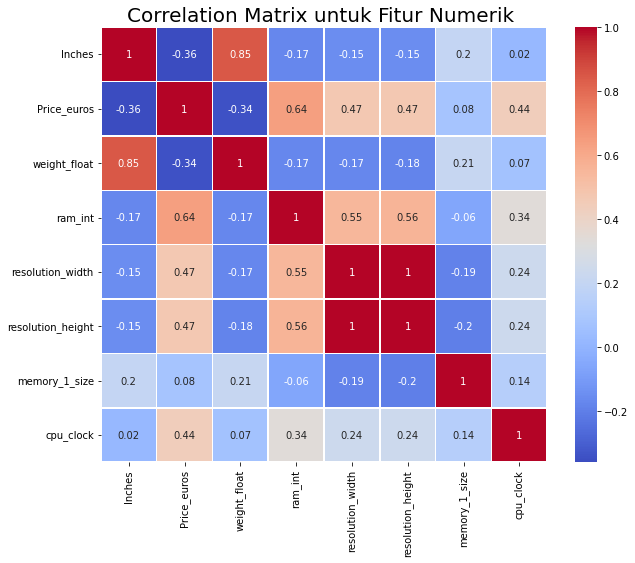

In [41]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr().round(2)
 
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

* Besar RAM memiliki pengaruh besar terhadap harga laptop
* Karena kolom Inches, weight_float, dan memory_1_size memiliki korelasi yang kecil terhadap price maka kolom tersebut didrop





In [42]:
# drop Inches, weight_float, memory_1_size, memory_count, dan memory_2_size karena korelasi yang kecil dengan price
df.drop(['Inches', 'weight_float', 'memory_1_size'], inplace=True, axis=1)
df.head()

,Company,Product,TypeName,Gpu,OpSys,Price_euros,ram_int,resolution_width,resolution_height,memory_1_type,cpu_brand,cpu_clock,cpu_series
1,Apple,Macbook Air,Ultrabook,Intel HD Graphics 6000,macOS,898.94,8,1440,900,Flash Storage,Intel,1.8,i5
2,HP,250 G6,Notebook,Intel HD Graphics 620,No OS,575.00,8,1920,1080,SSD,Intel,2.5,i5
5,Acer,Aspire 3,Notebook,AMD Radeon R5,Windows 10,400.00,4,1366,768,HDD,AMD,3.0,A9
7,Apple,Macbook Air,Ultrabook,Intel HD Graphics 6000,macOS,1158.70,8,1440,900,Flash Storage,Intel,1.8,i5
9,Acer,Swift 3,Ultrabook,Intel UHD Graphics 620,Windows 10,770.00,8,1920,1080,SSD,Intel,1.6,i5


#**Data Preparation**

Melakukan Encoding Fitur Kategori

In [43]:
for col in cat_columns:
  df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
  df.drop([col], axis=1, inplace=True)
df.head()

,Price_euros,ram_int,resolution_width,resolution_height,cpu_clock,Company_Acer,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,...,cpu_series_E,cpu_series_M,cpu_series_Pentium,cpu_series_i3,cpu_series_i5,cpu_series_i7,memory_1_type_Flash Storage,memory_1_type_HDD,memory_1_type_Hybrid,memory_1_type_SSD
1,898.94,8,1440,900,1.8,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,575.00,8,1920,1080,2.5,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
5,400.00,4,1366,768,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,1158.70,8,1440,900,1.8,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
9,770.00,8,1920,1080,1.6,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


Melakukan Train-Test-Split

In [44]:
y = df["Price_euros"]
X = df.drop(["Price_euros"],axis =1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 55)

Melakukan Standarisasi Data

In [45]:
scaler = StandardScaler()
numerical_features = X_train.select_dtypes(include=['float','int']).columns.to_list()
scaler.fit(X_train[numerical_features])
X_train[numerical_features] = scaler.transform(X_train.loc[:, numerical_features])
X_train[numerical_features].head()

,ram_int,resolution_width,resolution_height,cpu_clock
1187,-1.084875,0.672011,0.670528,0.555436
833,0.834520,0.672011,0.670528,0.125695
745,-2.044573,-1.503086,-1.511922,-1.378399
282,0.834520,0.672011,0.670528,0.555436
419,0.834520,0.672011,0.670528,-0.948658


Mengecek apakah X_train sudah terstandarisasi

In [46]:
X_train[numerical_features].describe().round(4)

,ram_int,resolution_width,resolution_height,cpu_clock
count,506.0000,506.0000,506.0000,506.0000
mean,-0.0000,0.0000,-0.0000,0.0000
std,1.0010,1.0010,1.0010,1.0010
min,-2.0446,-1.5031,-1.5119,-2.4528
25%,-1.0849,-1.5031,-1.5119,-0.9487
50%,0.8345,0.6720,0.6705,0.4480
75%,0.8345,0.6720,0.6705,0.5554
max,2.7539,0.6720,0.6705,2.9190


# **Modelling**

In [47]:
models = pd.DataFrame(index=['train_mse', 'test_mse'], 
                      columns=['KNN', 'RandomForest', 'Boosting'])

Model Development KNN

In [48]:
knn = KNeighborsRegressor(algorithm='kd_tree', n_neighbors=10)
knn.fit(X_train, y_train)
 
models.loc['train_mse','knn'] = mean_squared_error(y_pred = knn.predict(X_train), y_true=y_train)

Model Development Random Forest

In [49]:
RF = RandomForestRegressor(n_estimators=50, max_depth=16, random_state=55, n_jobs=-1)
RF.fit(X_train, y_train)
 
models.loc['train_mse','RandomForest'] = mean_squared_error(y_pred=RF.predict(X_train), y_true=y_train)          

Model Development Boosting

In [50]:
boosting = AdaBoostRegressor(learning_rate=0.05, random_state=55)                             
boosting.fit(X_train, y_train)
models.loc['train_mse','Boosting'] = mean_squared_error(y_pred=boosting.predict(X_train), y_true=y_train)

Standarisasi data untuk data test

In [51]:
X_test.loc[:, numerical_features] = scaler.transform(X_test[numerical_features])

# **Evaluasi Model**

In [52]:
mse = pd.DataFrame(columns=['train', 'test'], index=['KNN','RF','Boosting'])
 
model_dict = {'KNN': knn, 'RF': RF, 'Boosting': boosting}

for name, model in model_dict.items():
    mse.loc[name, 'train'] = mean_squared_error(y_true=y_train, y_pred=model.predict(X_train))/1e3 
    mse.loc[name, 'test'] = mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))/1e3
 
mse

,train,test
KNN,56.727486,82.015829
RF,11.800786,60.274538
Boosting,78.511647,88.1475


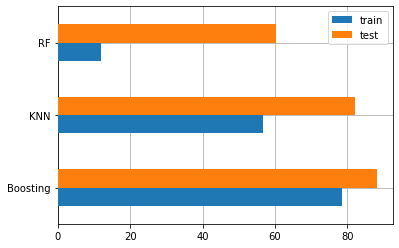

In [53]:
fig, ax = plt.subplots()
mse.sort_values(by='test', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)

In [54]:
prediksi = X_test.iloc[:-1].copy()
pred_dict = {'y_true':y_test[:-1]}
for name, model in model_dict.items():
    pred_dict['prediksi_'+name] = model.predict(prediksi).round(1)
 
pd.DataFrame(pred_dict)

,y_true,prediksi_KNN,prediksi_RF,prediksi_Boosting
269,880.0,1125.1,951.6,1021.7
188,989.0,1259.8,1065.8,1253.1
606,1399.0,1403.5,1221.0,1083.6
331,943.0,1100.4,993.0,1033.8
499,911.0,1135.7,952.5,1033.8
...,...,...,...,...
209,597.0,777.4,789.3,1021.7
741,665.0,734.0,790.8,1056.7
892,1699.0,1629.8,1624.1,1573.7
243,879.0,1046.0,1021.0,1286.9


Berdasar hasil prediksi model saat ini yang paling baik adalah random forest karena memiliki MSE terkecil pada data train dan test

# **Hyperparameter Tuning**

Hyperparameter Tuning untuk KNN dengan GridSearch



In [55]:
parameters = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    'algorithm' : ["auto",  "ball_tree", "kd_tree", "brute"],
}

In [56]:
clf = GridSearchCV(estimator = knn, param_grid = parameters, 
                          cv = 5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=KNeighborsRegressor(algorithm='kd_tree', n_neighbors=10),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30]})

In [57]:
print(clf.best_estimator_)
print('n_neighbors : ',(clf.best_estimator_.n_neighbors))

KNeighborsRegressor(algorithm='ball_tree')
n_neighbors :  5


In [58]:
knn_base_mse = evaluate(knn, X_test, y_test)

Model Performance
MSE =  82.01582860616534


In [59]:
knn_best_grid = clf.best_estimator_
knn_best_grid.fit(X_train, y_train)

knn_grid_mse = evaluate(knn_best_grid, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (knn_base_mse - knn_grid_mse) / knn_grid_mse))

Model Performance
MSE =  78.19806140837794
Improvement of 4.88%.


In [60]:
knn = knn_best_grid
knn.fit(X_train, y_train)
 
models.loc['train_mse','knn'] = mean_squared_error(y_pred = knn.predict(X_train), y_true=y_train)

Hyperparameter tuning untuk Random Forest

In [61]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [8, 16, 32, 64],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [60, 70, 80, 90, 100],
    'random_state': [55]
}
rf_grid_search = GridSearchCV(estimator = RF, param_grid = param_grid, 
                          cv = 5)

In [62]:
rf_base_model = RF
rf_base_model.fit(X_train, y_train)
rf_base_mse = evaluate(rf_base_model, X_test, y_test)

Model Performance
MSE =  60.274537682516424


In [63]:
rf_grid_search.fit(X_train, y_train)
rf_grid_search.best_params_

{'bootstrap': False,
 'max_depth': 32,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 70,
 'random_state': 55}

In [64]:
rf_best_grid = rf_grid_search.best_estimator_
rf_grid_mse = evaluate(rf_best_grid, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (rf_base_mse - rf_grid_mse) / rf_grid_mse))

Model Performance
MSE =  56.9081351686941
Improvement of 5.92%.


In [65]:
RF = rf_best_grid
RF.fit(X_train, y_train)

models.loc['train_mse','RandomForest'] = mean_squared_error(y_pred=RF.predict(X_train), y_true=y_train)  

Adaboost hyperparameter tuning

In [66]:
ada = AdaBoostRegressor()
search_grid={
    'n_estimators':[500,1000,1500],
    'learning_rate':[0.001,0.005, 0.01, 0.05, 0.1],
    'random_state':[55]}
boosting_grid=GridSearchCV(estimator=ada,
                    param_grid=search_grid,
                    cv=5)

In [67]:
boosting_grid.fit(X_train,y_train)
boosting_grid.best_params_

{'learning_rate': 0.01, 'n_estimators': 500, 'random_state': 55}

In [68]:
boost_base_mse = evaluate(boosting, X_test, y_test)

Model Performance
MSE =  88.14750013396304


In [69]:
boost_grid_mse = evaluate(boosting_grid, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (boost_base_mse - boost_grid_mse) / boost_grid_mse))

Model Performance
MSE =  87.49341186022788
Improvement of 0.75%.


In [70]:
boosting = boosting_grid                           

models.loc['train_mse','Boosting'] = mean_squared_error(y_pred=boosting.predict(X_train), y_true=y_train)

# **Evaluasi Model setelah hyperparameter tuning**

In [71]:
model_dict = {'KNN': knn, 'RF': RF, 'Boosting': boosting}
 
# # Hitung Mean Squared Error masing-masing algoritma pada data train dan test
for name, model in model_dict.items():
    mse.loc[name, 'train'] = mean_squared_error(y_true=y_train, y_pred=model.predict(X_train))/1e3 
    mse.loc[name, 'test'] = mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))/1e3
 
# Panggil mse
mse

,train,test
KNN,43.069575,78.198061
RF,8.871217,56.908135
Boosting,77.785318,87.493412


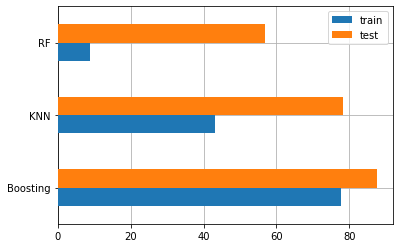

In [72]:
fig, ax = plt.subplots()
mse.sort_values(by='test', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)

In [73]:
prediksi = X_test.iloc[:-1].copy()
pred_dict = {'y_true':y_test[:-1]}
for name, model in model_dict.items():
    pred_dict['prediksi_'+name] = model.predict(prediksi).round(1)
 
pd.DataFrame(pred_dict)

,y_true,prediksi_KNN,prediksi_RF,prediksi_Boosting
269,880.0,1139.9,1069.3,1048.8
188,989.0,1338.4,1117.7,1230.0
606,1399.0,1308.6,1249.4,1106.0
331,943.0,1220.2,1102.7,1053.6
499,911.0,1004.4,1060.0,1053.6
...,...,...,...,...
209,597.0,779.5,773.2,1040.4
741,665.0,759.4,657.4,1050.8
892,1699.0,1747.2,1596.1,1550.8
243,879.0,929.5,1027.5,1291.4


Dari ketiga algoritma tersebut dapat disimpulkan yang terbaik adalah random forest karena memiliki MSE pada train dan test terkecil. Dan juga ketiga algoritma tersebut setelah dilakukan hyperparameter tuning mengalami peningkatan dan peningkatan terbaik diraih oleh random forest.